# Bayesian Inference Example
## Inferring Ion temperature from a neutron spectrum

Created: 8/2022

P. Knapp pfknapp@sandia.gov

W. Lewis willewi@sandia.gov


Copyright 2023 National Technology & Engineering Solutions of Sandia, LLC
(NTESS). Under the terms of Contract DE-NA0003525 with NTESS, the U.S.
Government retains certain rights in this software.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import jax.numpy as jnp
from jax import jit, jacfwd, jacrev, __version__

from matplotlib import rcParams
rcParams['axes.labelsize'] = 12
rcParams['axes.titlesize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['legend.fontsize'] = 12
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on Numpy v{np.__version__}")
print(f"Running on Arviz v{az.__version__}")
print(f"Running on Jax v{__version__}")

################################################
#   Versions used to generate this notebook
################################################
# Running on Python 3.7.16
# Running on PyMC v3.11.4
# Running on Numpy v1.20.3
# Running on Arviz v0.11.0
# Running on Jax v0.3.15 with jaxlib v0.3.15

seed = 1235844 #seed for random state used to generate data
Samples = 5000
Ascale = 1e3

Running on PyMC v3.11.4
Running on Numpy v1.20.3
Running on Arviz v0.11.0
Running on Jax v0.3.15


In [2]:
# Below is the model used to generate the spectral data
#Following L. Ballabio et al. Nucl. Fusion 38 (11), 1723 (1998) 
#for the neutron energy spectrum of DT fusion neutrons given the ion temperature we have:

def ballabio_data_model(E,ion_temp):    
 
    a1 = np.array([5.30509, 2.4736e-3, 1.84, 1.3818])
    a2 = np.array([5.1068e-4, 7.6223e-3, 1.78, 8.7691e-5])
    Eo = 14.021*1e3
    wo = 177.259
    Ti = ion_temp
    # computed parameters
    dE = (a1[0]/( 1 + a1[1]*Ti**a1[2] ))*Ti**( 2.0/3.0 ) + a1[3]*Ti
    dw = (a2[0]/( 1 + a2[1]*Ti**a2[2] ))*Ti**( 2.0/3.0 ) + a2[3]*Ti
    Emean = Eo + dE
    Sth = wo*(1+dw)*np.sqrt(Ti)/(2*np.sqrt(2*np.log(2)))

    Ebar = Emean*np.sqrt(1.0-1.5*Sth/Emean**2.0)
    S = (4./3.)*Ebar*(Emean-Ebar)        
    f = np.exp(-( 2*Ebar/S**2 ) * ( np.sqrt(E)-np.sqrt(Ebar))**2 )                   
    return f/np.sum(f)
    
def PDF_poiss(E,T,Y,base):
    PE = ballabio_data_model(E,T)

    rates = base*np.ones(E.shape[0]-1)
    E_mid = []

    for i in range(E.shape[0]-1):
        E_mid.append((E[i+1]+E[i])/2)
        rates[i] = 0.5*(E[i+1]-E[i])*(PE[i+1]+PE[i])*Y + 1*base

    E_mid = np.array(E_mid)
    
    # uncomment for reproducible random numbers
    rng = np.random.RandomState(seed)
    PoisE = rng.poisson(rates) + 0*rng.poisson(base)
    
    ## uncomment for irreproducible random numbers
    # PoisE = np.random.poisson(rates)
    
    return PoisE, E_mid
    

## Data Generation

First we must generate our observed data that we will use for our subsequent inference tasks.

We use the neutron energy spectrum defined above using the Ballabio model to produce a spectrum based on a specified ion temperature `Tion` and scale parameter `Y`.  The spectrum is binned into `Nbins` and the measured counts in each bin are modeled as a Poisson process with energy dependent rate $\lambda(E)$ proportional to the Ballabio model spectrum. We also assume an independent a constant background rate `base`. 

The Poisson distribution with rate $\lambda$ is given by $P(k) = \frac{\lambda^k}{k!}e^{-\lambda}$ and has mean and variance both equal to $\lambda$. Furthermore, the sum of independent Poisson processes is also a Poisson process with rate parameter equal to the sum of individual rate parameters. Later, we will directly use a Poisson likelihood function that exactly matches the data generating process laid out here. To start, we note that in the large rate limit, the Poisson distribution limits to a Normal distribution with mean and variance $\lambda_{tot}(E)=\lambda(E) + \lambda_{base}$. So we will also consider this approximation in constructing the likelihood.

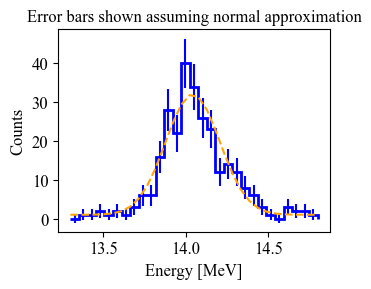

In [3]:
Nbins = 30
Tion = 4.75
Y = 5.0
base = 1.0
noise_base = 1.0
E = np.linspace(13.3*10**(3),14.8*10**(3),Nbins)

dEbin = np.diff(E)[0]

data, E_mid = PDF_poiss(E,Tion,Y,base)
#noise_total = np.sqrt( np.maximum(data,base*np.ones_like(data) ) )
noise_total = np.sqrt((data+noise_base))


fig, ax0 = plt.subplots(ncols=1, nrows = 1, figsize=(3.5, 3.0))
plt.stairs(data, edges = E/1e3, linewidth = 2, color = 'blue')
plt.errorbar(E_mid/1e3, data, noise_total, ls = 'none', color = 'blue') #[np.minimum(noise_total, data), noise_total]
ff = ballabio_data_model(E,Tion)
plt.plot(E/1e3,np.sum(data-base)*ff + base, ls = '--', color = 'orange')
plt.xlabel('Energy [MeV]')
plt.ylabel('Counts')
plt.title('Error bars shown assuming normal approximation')
plt.tight_layout()


# Uncomment to save the data for reproducibility
#plt.savefig('test_data.jpg',dpi=300,format = 'jpeg')
#np.savez('test_data.npz',data = data, E = E, E_mid = E_mid, noise_total = noise_total)

## Normal likelihood and the Laplace approximation

In this portion of the notebook, we assume uniform priors and a Normal likelihood function with known variance given by the observed counts. We also apply the Laplace approximation which approximates the posterior distribution with a  normal distribution centered on the posterior mode. Since we use uniform priors, this is the same as the parameter value at the maximum likelihood. In this case, the approximating multivariate normal distribution can be found by determining the location of the peak via maximum likelihood estimation, and the covariance matrix can be approximated using the Hessian evaluated at this location as we will show.  In particular, this approximation corresponds to recasting the problem of Bayesian inference as an optimization to find the peak in the likelihood, and, by taylor expansion, determine the covariance via the Hessian.  For numerical convenience we operate with **log-likelihood** which allows us to search for a minimum rather than a maximum.  For a normal distribution we have

$$ \log ( L ) \propto -\sum (y_i -f(\theta))^2/2\sigma_i^2 $$

where $f(\theta)$ is our model of the neutron spectrum as a function of the model parameters and $\sigma_i(E)$ is the (energy bin dependent) variance specified by the number of counts in that bin.  

Below we use the `scipy.optimize.minimize` method to find the set of parameters $\theta_o$ that minimizes the log-likelihood function. We note that the Laplace approximation relies on accurately locating this minimum.

In the problem below, we also work with the Brysk approximation (H. Brysk, Plasma Physics $\textbf{15}$, 611 (1973)) to the neutron spectrum rather than the full Ballabio expression. This allows the problem to be tractable analytically.  In this model, the variance of the spectrum is directly related to the ion temperature, but we leave the central energy as free parameter that does not depend on the ion temperature.  This gives us four parameters, an amplitude, the ion temperature, a shift from the nominal central energy of the spectrum, and an additive baseline:

$$ \theta = \{A, T_{ion}, \delta E, C\}$$

Our task is to find the distribution of the four parameters that best matches the observed data.

In [4]:
mn = 1.008
mh = 4.001
mr = mn/(mn + mh)
En = 14.021*1e3  

def dist(theta):
    th1, th2, th3, th4 = theta
    sigma = np.sqrt(2.0*En*mn*th2/(mn+mh))
    f = np.exp( -(E_mid-En-10.0*th3)**2/( 2*sigma**2 ) ) / (np.sqrt(2*np.pi)*sigma**2 )
    return Ascale*th1*f/np.sum(f) + th4

def myfun(theta):
    f = dist(theta)
    return np.sum((data - f)**2/2.0/noise_total**2)

from scipy.optimize import minimize, least_squares
x0 = [1, 3.0, 1.0, 0.0]
x = minimize(myfun, x0, method = 'L-BFGS-B',bounds = [[0.001, 10], [0.5, 10.0], [-10.0, 10.0], [-10, 10]])
print(x["x"])

[0.22927603 4.44514251 2.22598982 0.92421679]


Now that we know the location of the peak, we must find the width of the distribution about the optimum.  It is shown in the companion article to this notebook that this is equal to the inverse of the second derivative matrix (the Hessian $H$) evaluated at the optimum point.  The Hessian can be determined analytically in limited cases, via finite-difference, or as we show below using an auto-differentiation software.

In the example below we rewrite the log-likelihood in `Jax`, using the `jax.numpy` library.  All of the mathematical operations defined in this library come with predefined derivatives.  This allows us to define Hessian of the function `myfunc` by computing the Jacobian twice: 

``hessian = jit(jacfwd(jacrev(myfunc)))``  

Then we can evaluate the hessian at the optimum and compute the inverse, giving us the covariance matrix $\Sigma$ .  

The multivariate normal distribution is then defined as

$$ p(\theta | y) \propto \exp( -\frac{1}{2}(\theta - \theta_o)^T \Sigma (\theta - \theta_o)  ) $$

We can then draw samples from this distribution and plot the resulting correlation matrix.

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: covariance is not positive-semidefinite.


Ion Temperature Mean =  4.449231743126184
Ion Temperature Sted. Dev. =  0.7503301893581538


<Figure size 640x480 with 0 Axes>

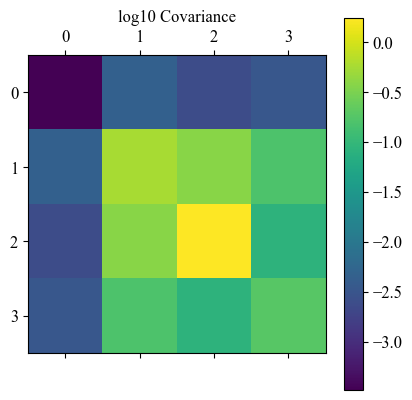

<Figure size 640x480 with 0 Axes>

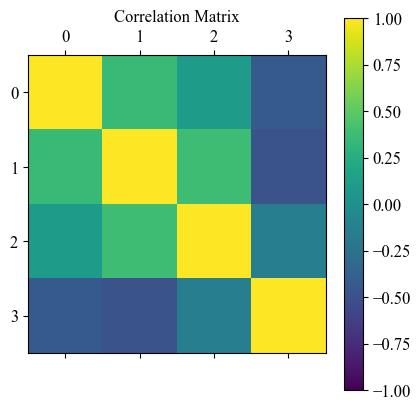

In [5]:
## uncomment if using precomputed data file
#npzfile = np.load('test_data.npz')
#y = npzfile['data']
#sig = npzfile['noise_total']
#E_mid = npzfile['E_mid']

## Uncomment to use data in memory
y = data
sig = noise_total
E_mid = E_mid

def myfunc(th):
    sigma = 2.0*En*mn*th[1]/(mn+mh)
    f = jnp.exp( -(E_mid-En-10.0*th[2])**2/( 2.0*sigma )) / jnp.sqrt(2*np.pi*sigma )  
    return jnp.sum( (y - (Ascale*th[0]*f/jnp.sum(f) + th[3]))**2/2./sig**2 )

hessian = jit(jacfwd(jacrev(myfunc)))

precision = hessian(np.array(x['x']))

cov = np.linalg.inv(precision)
plt.figure()
plt.matshow(np.log10(np.abs(cov)))
plt.colorbar()
plt.title("log10 Covariance")
mvsamples = np.random.multivariate_normal(x['x'], -cov, size=40000)
datadict = {
    "amplitude": mvsamples[:,0],
    "Tion": mvsamples[:,1],
    "deltaE": mvsamples[:,2],
    "constant":mvsamples[:,3]
}
dataset = az.convert_to_inference_data(datadict)

corr = np.corrcoef(mvsamples, rowvar = False)
plt.figure()
plt.matshow(corr, vmin = -1, vmax = 1)
plt.colorbar()
plt.title("Correlation Matrix")

print("Ion Temperature Mean = ", np.mean(datadict["Tion"]))
print("Ion Temperature Sted. Dev. = ", np.std(datadict["Tion"]))


Above is the full solution of the inference problem under the Laplace approximation.  We can instead relax this assumption and sample the posterior more generally using a probabilistic programming language.  Below we illustrate solving this problem using `PyMC3`.  This language allows us to define priors on the parameters, with bounds if necessary, and to define the likelihood distribution.  `PyMC3` takes advantage of auto-differentiation to perform sampling, but uses its own built-in library to do so.  Therefore, we must rewrite our physics model in using the built-in `pymc.math` library.

We are still using the gaussian approximation for the neutron spectrum, so that we can directly compare to the Laplace approximation example above.

We begin by defining priors on each of the four parameters

$$A \sim Normal(\mu = \sum_i (y_i), \sigma = 0.2\sum_i (y_i))$$
$$ T_{ion} \sim Uniform(0.5, 6.0) $$
$$ \delta E \sim Uniform(0.0, 5.0) $$
$$ C \sim Uniform(0, 100)  $$

All of the parameters have uniform priors except for the amplitude.  For the amplitude we use a normal distribution with mean determined by the sum of the data points $y_i$ normalized by a predefined amplitude scale, and standard deviation as a fixed fraction of this sum.  These distributions are defined in the following code block

``
    amp = pm.Normal("amplitude", mu=np.sum(data/Ascale), sigma=0.2*np.sum(data/Ascale))
    Tion = pm.Uniform('Tion',lower=0.5,upper=6.0)
    deltaE = pm.Uniform('deltaE',0.0,5)
    const = pm.Uniform('constant', 0, 100)
``

Next we define the likelihood.  We assume a normal likelihood, as we did in the Laplace approximation.  The mean of this distribution is the model spectrum computed for a given set of parameters.  The standard deviation is defined as the noise on the observations, and another parameter is passed `observed = data`, telling the tool that this is a likelihood and the model values should be compared to the data.  This is defined by the following code
``
    y_observed = pm.Normal(
        "y_observed",
        mu=1e4*amp*PDF_G(E_mid,Tion, 10*deltaE) + 10*const,
        sigma=noise_total,
        observed=data,
    )
``

Note that we use several constant multipliers in the definition of the mean.  This is done so that the sampler can sample parameter values that are of a similar magnitude, which are then transformed to the correct magnitude when computing the mean.  


In [6]:
def PDF_G(E,T,dE):    
    #Probability distribution for DD neutron energy
    sigma = np.sqrt(2.0*En*mn*T/(mn+mh))
    f = pm.math.exp( -(E-En-dE)**2/( 2*sigma**2 ) ) / (np.sqrt(2*np.pi)*sigma )
    return f/pm.math.sum(f)

with pm.Model() as normal_model:
    amp = pm.Normal("amplitude", mu=np.sum(data/Ascale), sigma=0.2*np.sum(data/Ascale))
    Tion = pm.Uniform('Tion',lower=0.5,upper=10.0)
    deltaE = pm.Uniform('deltaE',0.0,10)
    const = pm.Uniform('constant', 0, 20)
    y_observed = pm.Normal(
        "y_observed",
        mu=Ascale*amp*PDF_G(E_mid,Tion, 10*deltaE) + const,
        sigma=noise_total,
        observed=data,
    )

With our model specified, we can now sample it.  First we sample the prior predictive.  '

`` prior = pm.sample_prior_predictive() ``

This allows us to see the space of potential observations allowed by the prior distributions we have defined.  By carefull scrutinizing the prior predictive distribution we can assess whether or not the priors we have defined are unduly constraining the solution, if the allowed space is even remotely consistent with the observations, or if the observation is even sensitive to the parameters of the model.

Next, we define a sampling algorithm and sample our model.  For this example we use Metropolis-Hastings.  This is a classic sampling algorithm which does not require the computation of gradients.  

``  step = pm.Metropolis(tune = True, tune_interval = 25)
    posterior = pm.sample(step = step, draws=40000)``

The we can sample the posterior predictive and store our results in an arviz dataset.

``
    posterior_pred_gaussian = pm.sample_posterior_predictive(posterior)
    post_az = az.from_pymc3(posterior)
    ``
    

In [7]:
with normal_model:
    prior = pm.sample_prior_predictive(samples = Samples)
    step = pm.Metropolis(tune = True, tune_interval = 25)
    posterior = pm.sample(step = step, draws=Samples)
    posterior_pred_gaussian = pm.sample_posterior_predictive(posterior)
    post_az = az.from_pymc3(posterior)


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  after removing the cwd from sys.path.
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [constant]
INFO:pymc3:>Metropolis: [constant]
>Metropolis: [deltaE]
INFO:pymc3:>Metropolis: [deltaE]
>Metropolis: [Tion]
INFO:pymc3:>Metropolis: [Tion]
>Metropolis: [amplitude]
INFO:pymc3:>Metropolis: [amplitude]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 13 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 13 seconds.
The number of effective samples is smaller than 10% for some parameters.


Once sampled, we can view the results in a number of different ways.  Below we plot the distribution of each of the four parameters using `pm.plot_posterior` and the traces from the sample using `pm.plot_trace`.  The trace shows as a function of sampling iteration how each of the parameters varied.  This is useful to look for pathologies in the sampling.  In our case the samples appear to be highly uncorrelated and sufficiently random.  We also plot a histrogram of the prior and posterior for the ion temperature only, showing that the posterior distribution is significantly different from the prior and the bulk of the samples are very far from the boundaries.  This indicates that our prior choice is not significantly impacting the posterior for this parameter. Finally we print the mean and standard deviation of the ion temperature.  The mean has been reduced slightly, approaching the true value more closely, and the standard deviation has been reduced modestly with this model.

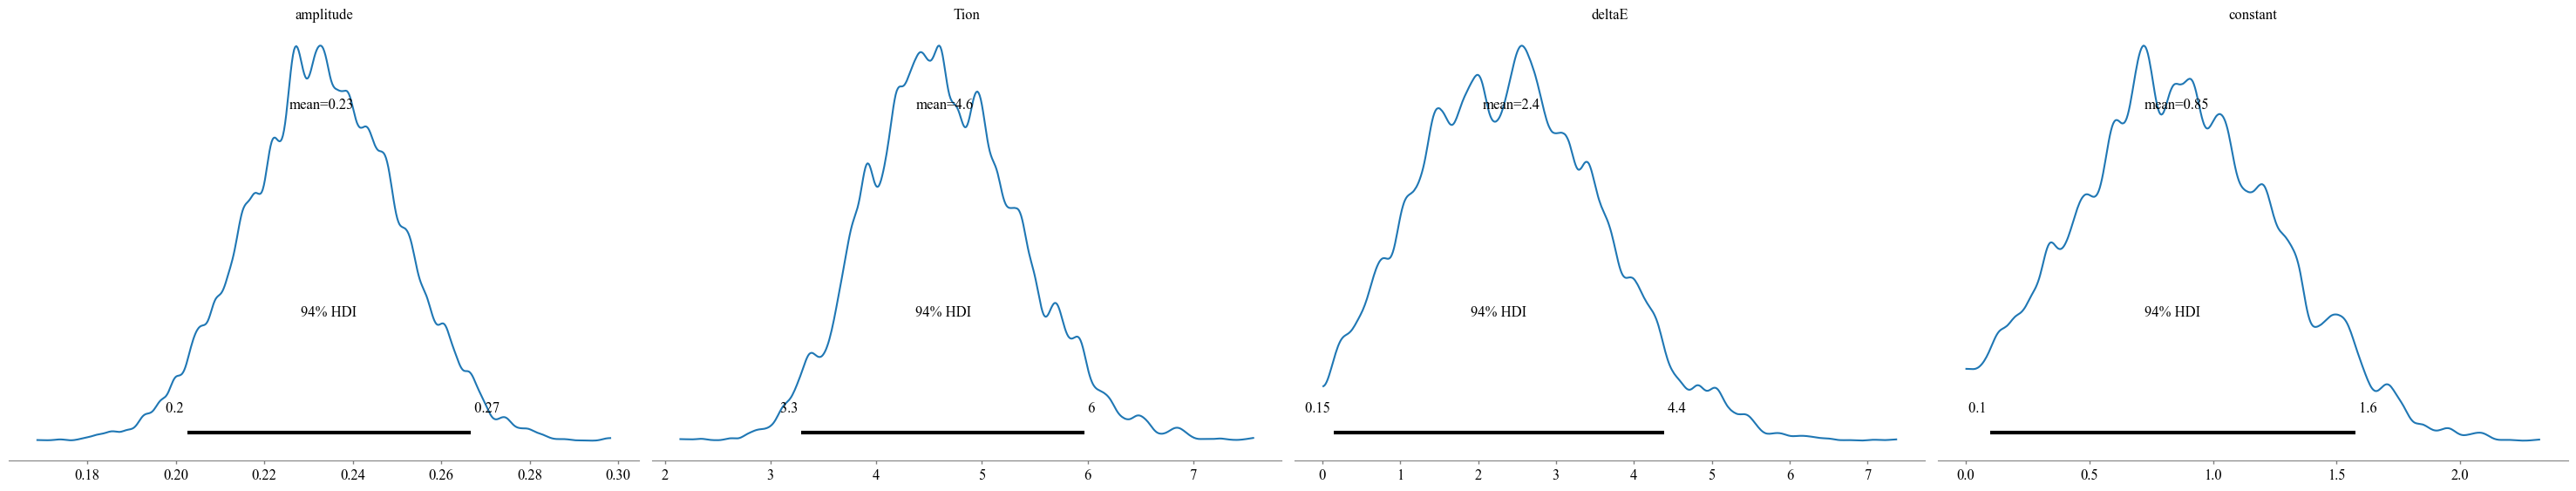

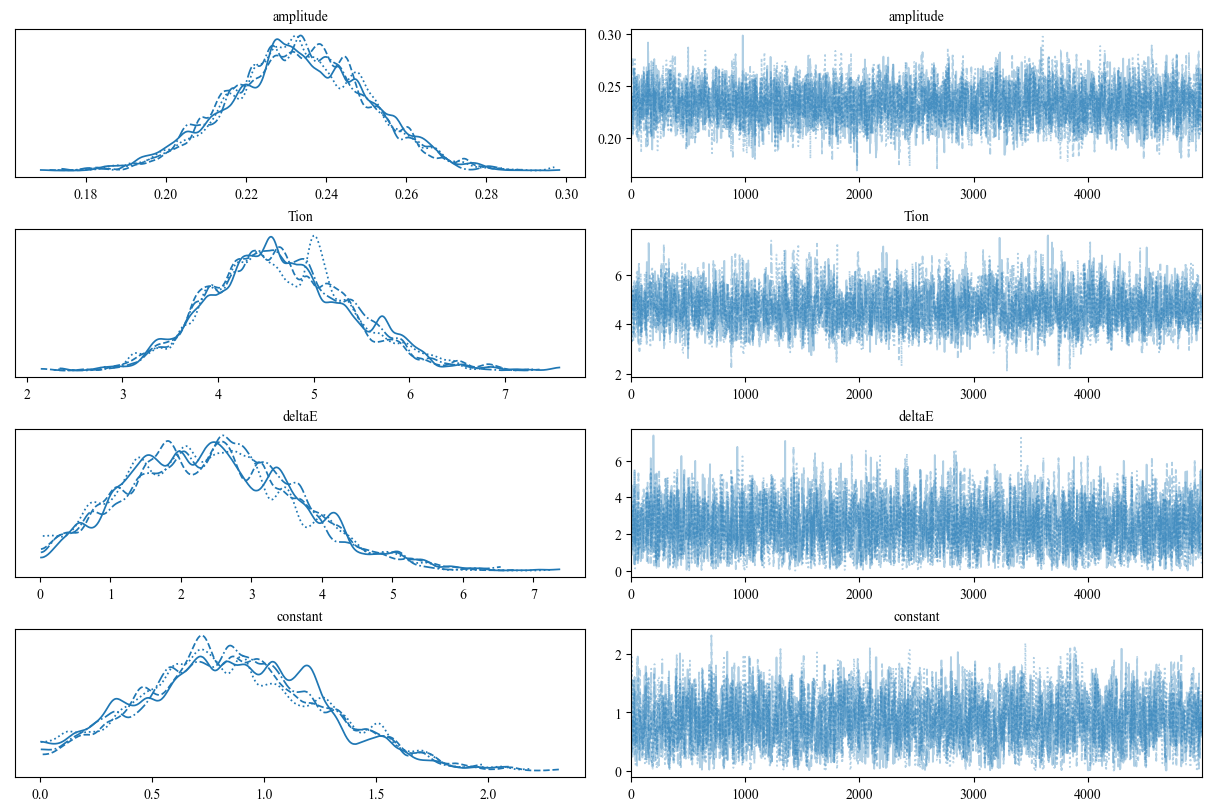

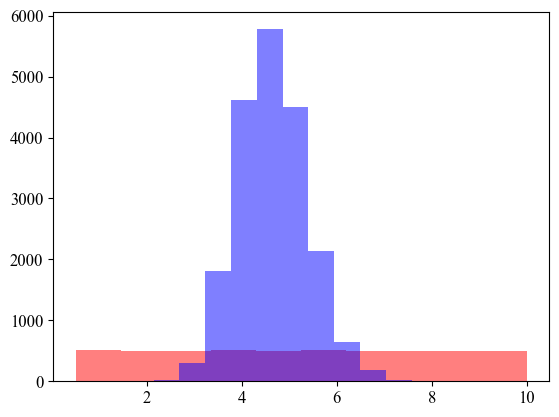

Ion Temperature Mean =  4.646885114487222
Ion Temperature Sted. Dev. =  0.7245368053023483


In [8]:
with normal_model:
    pm.plot_posterior(posterior)
    pm.plot_trace(posterior)    

plt.figure()
plt.hist(prior['Tion'],color='r',alpha=0.5)
plt.hist(posterior.get_values('Tion'),color='b',alpha=0.5)
plt.show()

print("Ion Temperature Mean = ", np.mean(posterior.get_values('Tion')))
print("Ion Temperature Sted. Dev. = ", np.std(posterior.get_values('Tion')))


We can view the full distribution by using a so-called corner, or pair plot.  This allows us to look at the marinal distributions for each parameter as well as the pairwise distributions of each combination of two parameters.  Below we produce pair plots for the posterior found using the Laplace approximation (red) and the MCMC sampled version (blue).  We can immediately see that the distributions are similar, but the blue distribution shows some interesting features.  Remember that we imposed priors with bounds in this model.  In particular we can see that the distribution of the constant parameter in the bottom right corner is being impacted by the prior.  We imposed a lower bound of 0, reasoning that for a counting process a negative offset is not physically meaningful.  Accordingly, because there is anti-correlation between the constant and both the temperature and the amplitude, the distributions of each of these parameters are effected by the non-negativity prior on constant offset.  Often, we don't want our prior to have a strong effect on the posterior, but in this case the prior is imposing a physically meaningful constraint, and we do want this constraint to be reflected in the posterior.  

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/arviz/plots/pairplot.py:229: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  UserWarning,


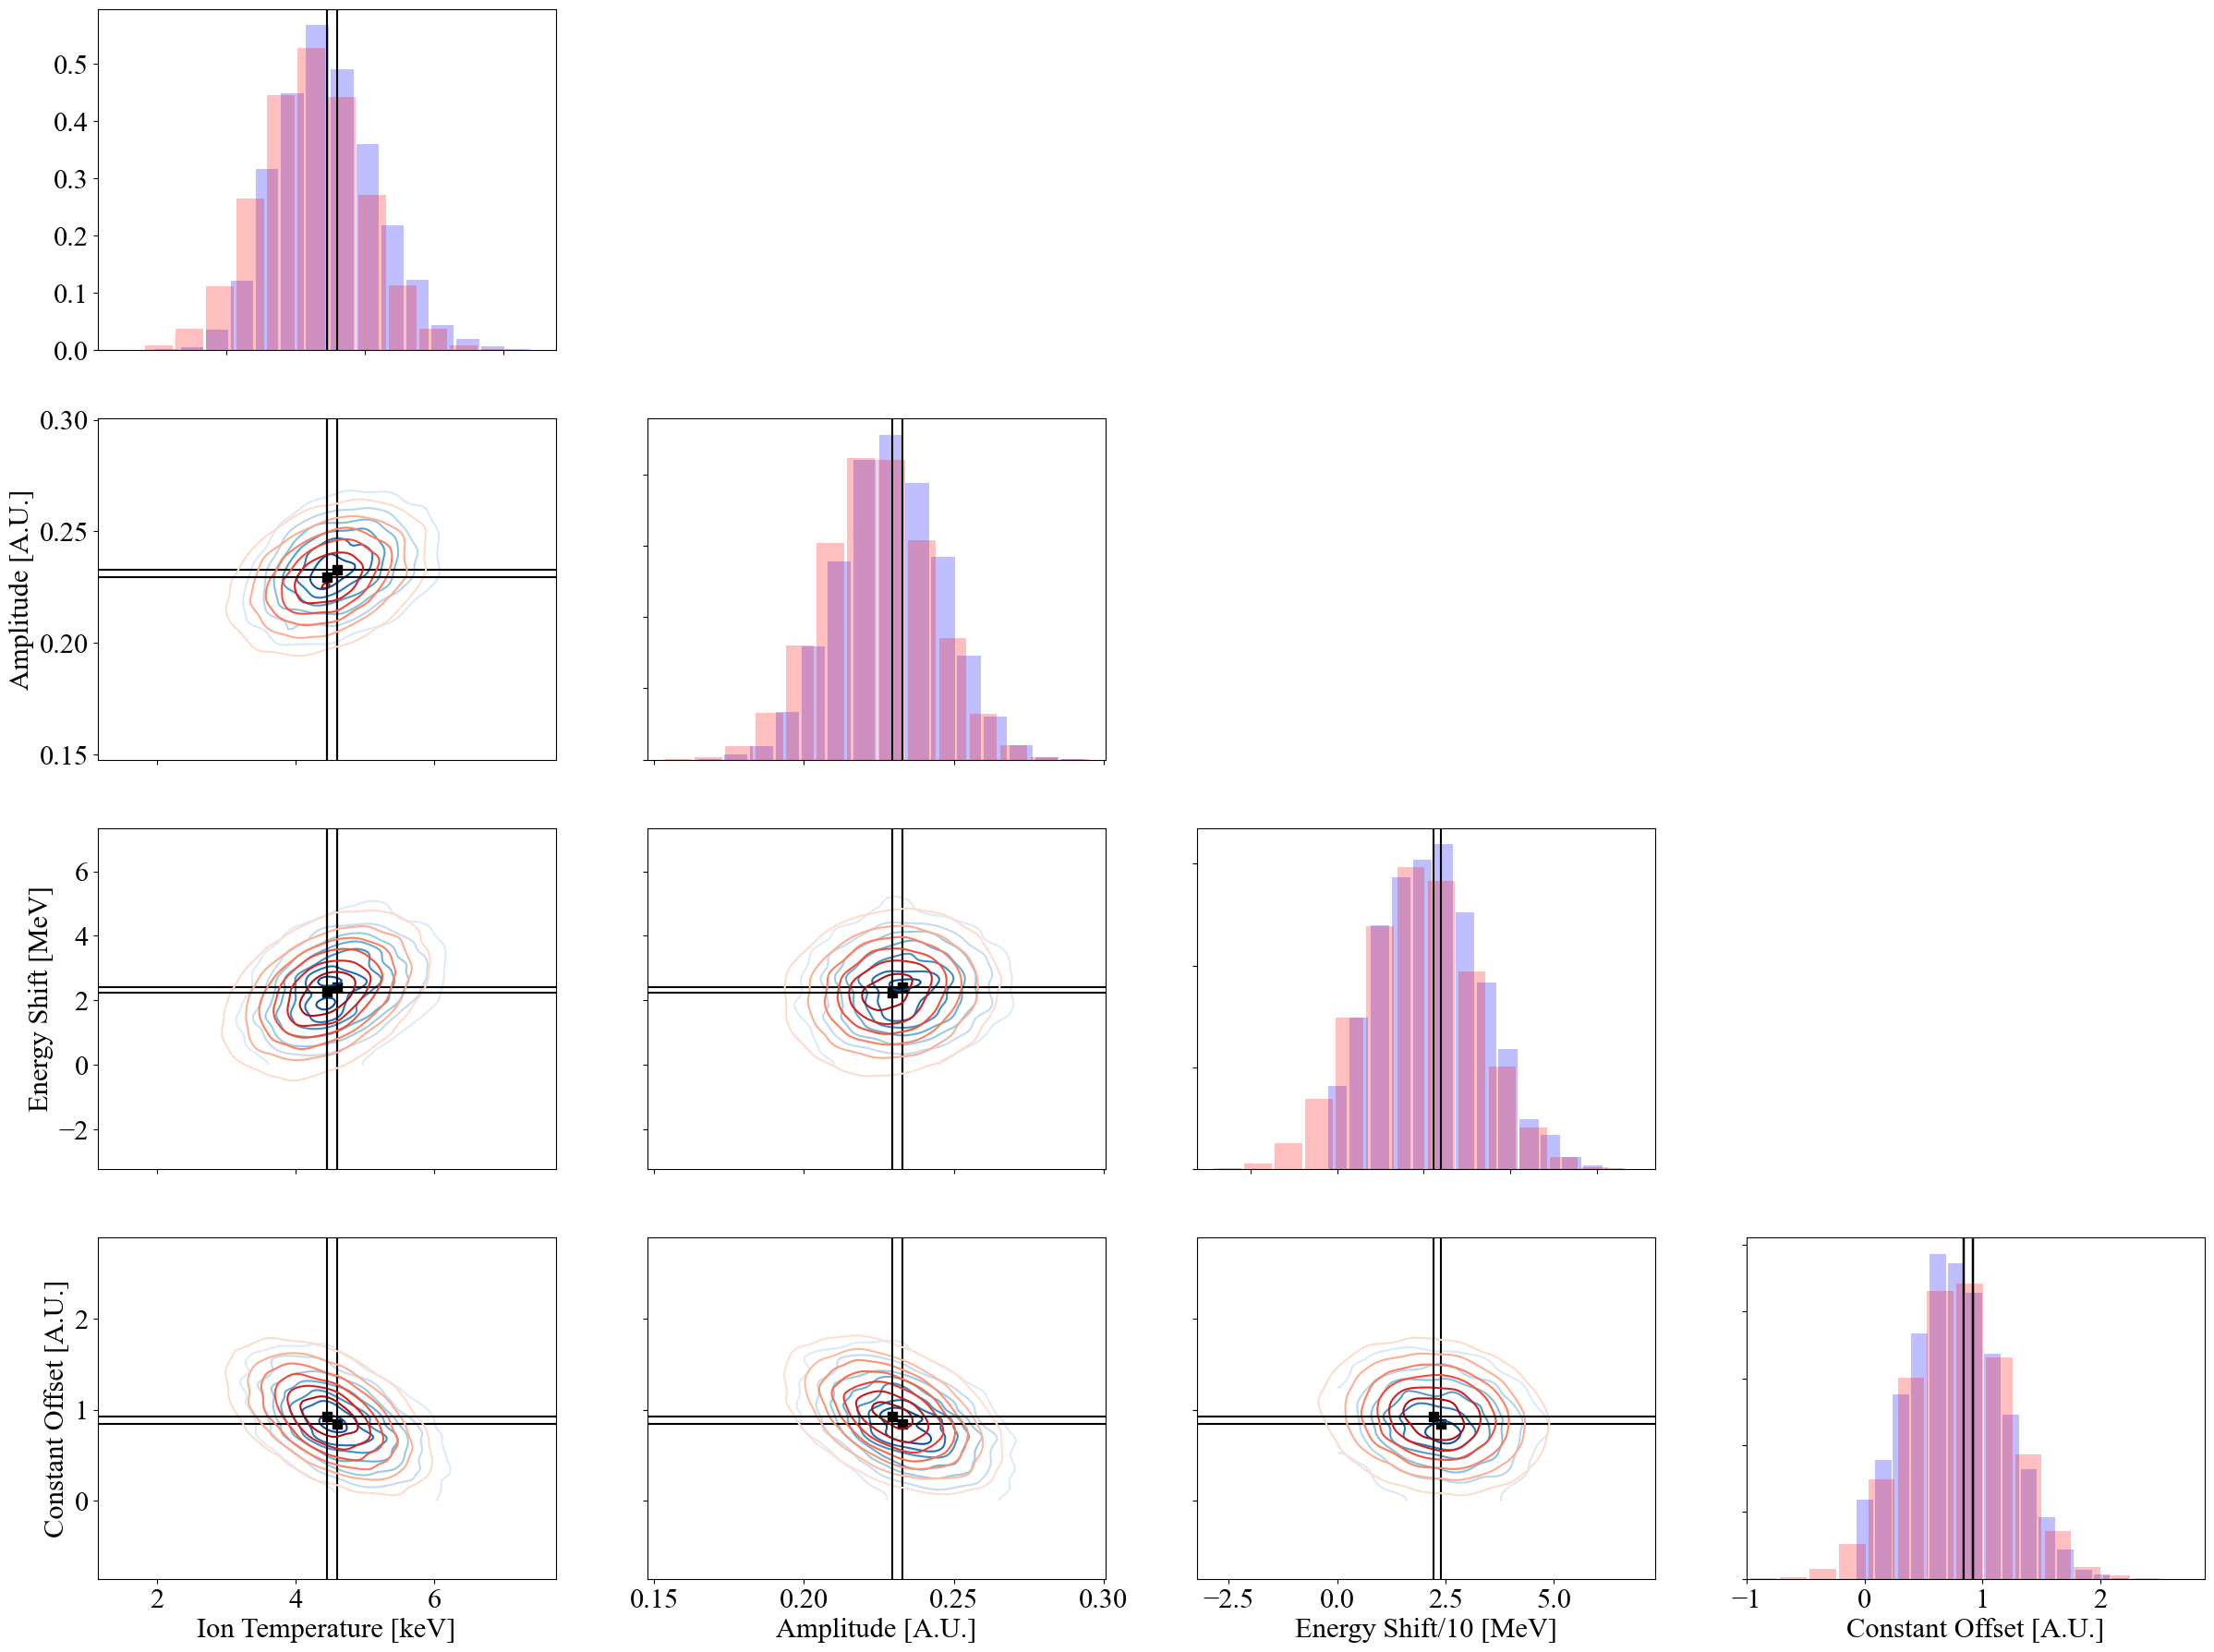

In [9]:
ax = az.plot_pair(post_az,
            var_names=['Tion','amplitude', 'deltaE','constant'],
            kind='kde',
            marginals = True,
            divergences=True,
            textsize=22,
            point_estimate = 'median',
            kde_kwargs = {'contour_kwargs':{"colors":None, "cmap":plt.cm.Blues},
            'contourf_kwargs':{"alpha":0}},
            marginal_kwargs = {'kind':'hist','hist_kwargs':{'bins':15, 'color':'blue','alpha':0.25}})

az.plot_pair(dataset, ax = ax,
            var_names=['Tion','amplitude', 'deltaE','constant'],
            kind='kde',
            marginals = True,
            divergences=True,
            textsize=22,
            point_estimate = 'median',
            kde_kwargs = {'contour_kwargs':{"colors":None, "cmap":plt.cm.Reds},
            'contourf_kwargs':{"alpha":0}},
            marginal_kwargs = {'kind':'hist','hist_kwargs':{'bins':15, 'color':'red','alpha':0.25}})             


ax[0][0].set_ylabel(" ")
ax[0][0].set_xlim(ax[1][0].get_xlim())
ax[0][0].set_xticks([3.0,5.0,7.0])

ax[1][0].set_ylabel("Amplitude [A.U.]")
ax[1][0].set_yticks([0.15, 0.2, 0.25, 0.3])

ax[2][0].set_ylabel("Energy Shift [MeV]")
ax[3][0].set_ylabel("Constant Offset [A.U.]")
ax[3][0].set_xlabel("Ion Temperature [keV]")

ax[1][1].set_xlim(ax[2][1].get_xlim())
ax[1][1].set_xticks([0.15, 0.2, 0.25, 0.3])

ax[3][1].set_xlabel("Amplitude [A.U.]")
ax[3][2].set_xlabel("Energy Shift/10 [MeV]")
ax[3][3].set_xlabel("Constant Offset [A.U.]")

ax[2][2].set_xlim(ax[3][2].get_xlim())
ax[2][2].set_xticks([-2, 0, 2, 4, 6])

ax[3][3].set_xlim(ax[3][0].get_ylim())
ax[3][3].set_xticks([-1, 0, 1, 2])

#plt.savefig('compare_laplace_mcmc_wmarginals.jpg',dpi=300,format = 'jpeg')


 We can also compute the correlation matrix from the new posterior samples.  Below it is plotted showing that the correlation structure is nearly identical to that found using the Laplace approximation as expected.

<Figure size 640x480 with 0 Axes>

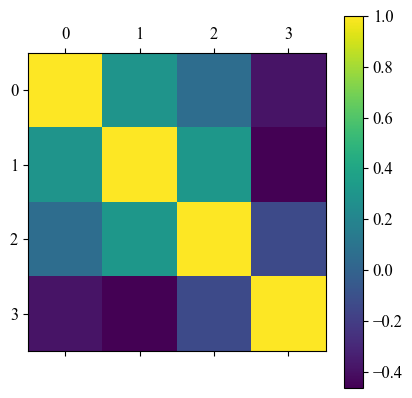

In [10]:
post_array = np.array([post_az.posterior.amplitude.data[0], post_az.posterior.Tion.data[0],
                      post_az.posterior.deltaE.data[0], post_az.posterior.constant.data[0]])

corr_2 = np.corrcoef(post_array, rowvar = True)
plt.figure()
plt.matshow(corr_2)
plt.colorbar()

Finally, we plot the prior predictive (light blue) and posterior predictive (red) along with the observed data.  We clearly see that the posterior predictive interval produces an excellent match to the data with a much narrower distribution than the prior predictive.  All of this indicates that our model is functioning as intended and producing a meaningful posterior.

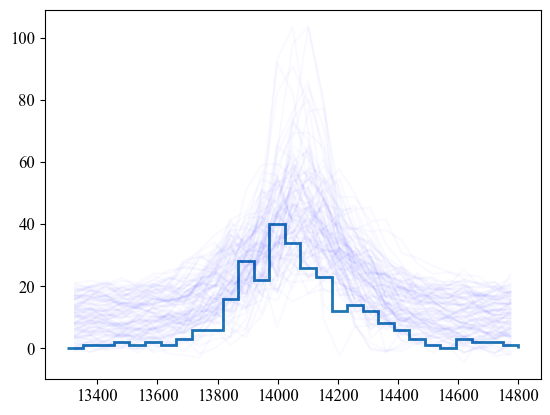

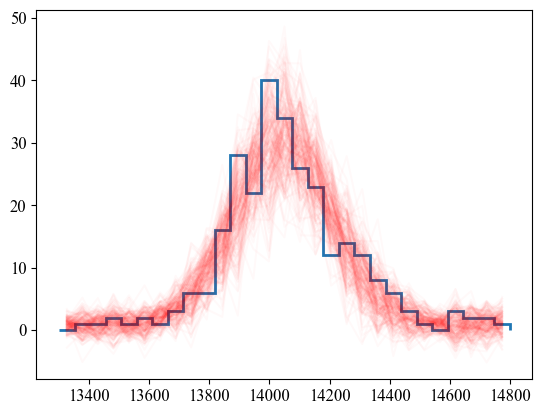

In [11]:
output_post = posterior_pred_gaussian['y_observed'][::100,:]
output_prior = prior['y_observed'][::50,:]

plt.figure()
plt.stairs(data,E, linewidth=2)
for o in output_prior:
    plt.plot(E_mid,o, color='blue', alpha = 0.025)
    
plt.figure()
plt.stairs(data,E, linewidth=2)
for o in output_post:
    plt.plot(E_mid,o, color='red', alpha = 0.025)
    


Now we want to improve the physical fidelity of our model by using the Ballabio formalism as our forward physics model.  This model is closer to the physics used to generate the data (in fact it exactly corresponds to the physics!).  It also has one fewer free parameter because the mean energy shift is computed as part of the model, not an ad-hoc parameter.  We should expect a higher confidence inference using this model.  We define the Ballabio model below using `pm.math` library to allow for the use of gradients.

In [12]:
#Following L. Ballabio et al. Nucl. Fusion 38 (11), 1723 (1998) 
#for the neutron energy spectrum of DD fusion neutrons given the ion temperature we have:
def ballabio(E,ion_temp):    
 
    a1 = np.array([5.30509, 2.4736e-3, 1.84, 1.3818])
    a2 = np.array([5.1068e-4, 7.6223e-3, 1.78, 8.7691e-5])
    Eo = 14.021*1e3
    wo = 177.259
    Ti = ion_temp
    # computed parameters
    dE = (a1[0]/( 1 + a1[1]*Ti**a1[2] ))*Ti**( 2.0/3.0 ) + a1[3]*Ti
    dw = (a2[0]/( 1 + a2[1]*Ti**a2[2] ))*Ti**( 2.0/3.0 ) + a2[3]*Ti
    Emean = Eo + dE
    Sth = wo*(1+dw)*pm.math.sqrt(Ti)/(2*pm.math.sqrt(2*pm.math.log(2)))

    Ebar = Emean*pm.math.sqrt(1.0-1.5*Sth/Emean**2.0)
    S = (4./3.)*Ebar*(Emean-Ebar)        
    f = pm.math.exp(-( 2*Ebar/S**2 ) * ( pm.math.sqrt(E)-pm.math.sqrt(Ebar))**2 ) 
    return f/pm.math.sum(f)                  


Now we only have three free parameters $\theta = \{A, T_{ion}, C \}$.  We use the similar priors as before, except we allow a broader range of temperatures.  The likelihood is defined in exactly the same way as before.  In this example, we use the default sampler instead of Metropolis-Hastings.  This sampler in called NUTS, a variety of Hamiltonian Monte-Carlo that utilizes gradient information to help achieve convergence with fewer samples.

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  del sys.path[0]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [constant, Tion, amplitude]
INFO:pymc3:NUTS: [constant, Tion, amplitude]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 19 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 19 seconds.


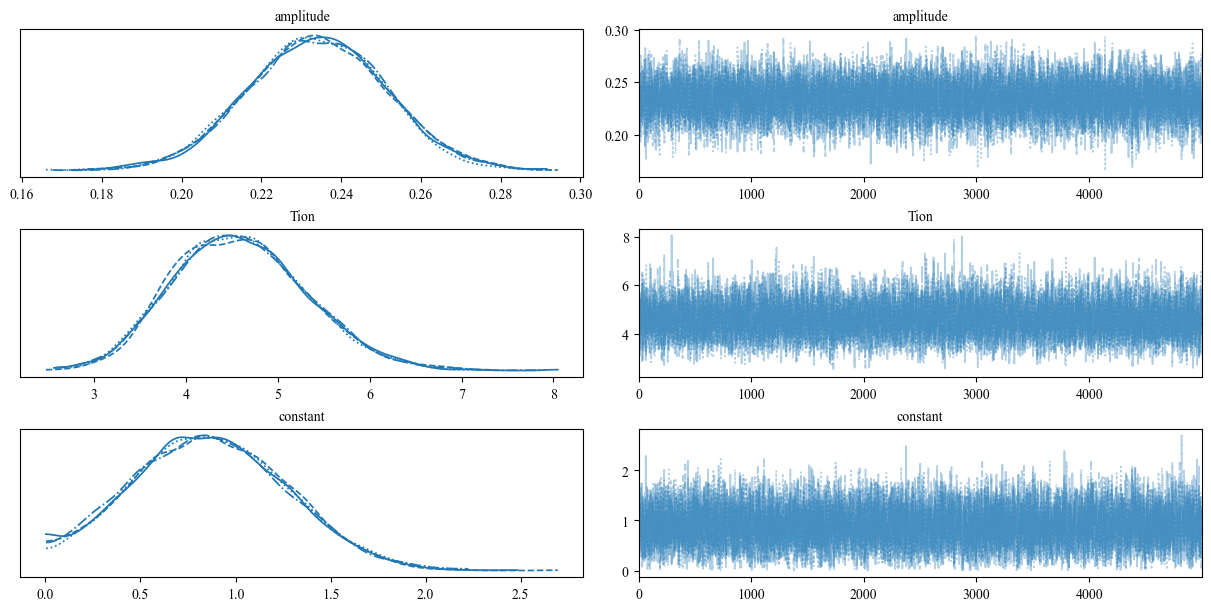

In [13]:
with pm.Model() as ballabio_model:
    amp = pm.Normal("amplitude", mu=np.sum(data/Ascale), sigma=0.2*np.sum(data/Ascale))
    Tion = pm.Uniform('Tion',lower=0.5,upper=10.0)
    const = pm.Uniform('constant', 0, 10)
    y_observed = pm.Normal(
        "y_observed",
        mu=Ascale*amp*ballabio(E_mid,Tion) + const,
        sigma=noise_total,
        observed=data,
    )
    output = pm.Deterministic('output',amp*ballabio(E_mid,Tion) + const)
    prior = pm.sample_prior_predictive()
    posterior = pm.sample(draws = Samples, target_accept = 0.9)
    posterior_pred_ballabio = pm.sample_posterior_predictive(posterior)
    post_az_ballabio = az.from_pymc3(posterior)

    pm.plot_trace(posterior, var_names = ['amplitude','Tion','constant'])

We can make all of the same plots as before.  Below we show only the histogram of the prior and posterior ion temperature.  The resulting mean ion temperature is much closer to the true value now with a slightly narrower distribution.  

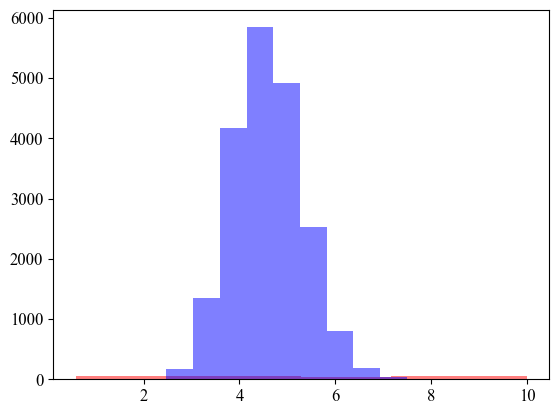

Ion Temperature Mean =  4.591906468461781
Ion Temperature Sted. Dev. =  0.724468123221572


In [14]:
plt.hist(prior['Tion'],color='r',alpha=0.5)
plt.hist(posterior.get_values('Tion'),color='b',alpha=0.5)
plt.show()

print("Ion Temperature Mean = ", np.mean(posterior.get_values('Tion')))
print("Ion Temperature Sted. Dev. = ", np.std(posterior.get_values('Tion')))


We would like to compare the previous model to this Ballabio model, but because they have different parameters we can't compare them exactly in a straightforward way (see the leave-one-out score at end of this notebook for one approach to comparison).  However, they both have the ion temperature as a parameter, which is the main parameter of interest, as well as the amplitude.  Below is a pair-plot showing the posterior distribution of $T_{ion}$ and $A$ for the Ballabio model (blue) and the Brysk model (red).  We see a small shift in the location of median in ion temperature and negligible change in the amplitude.  We also plot the marginal distribution of $T_{ion}$ to see the change more clearly.


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/arviz/plots/pairplot.py:229: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  UserWarning,


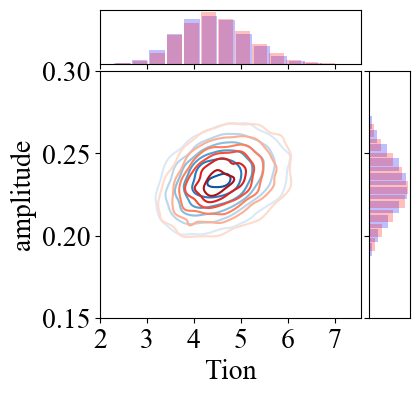

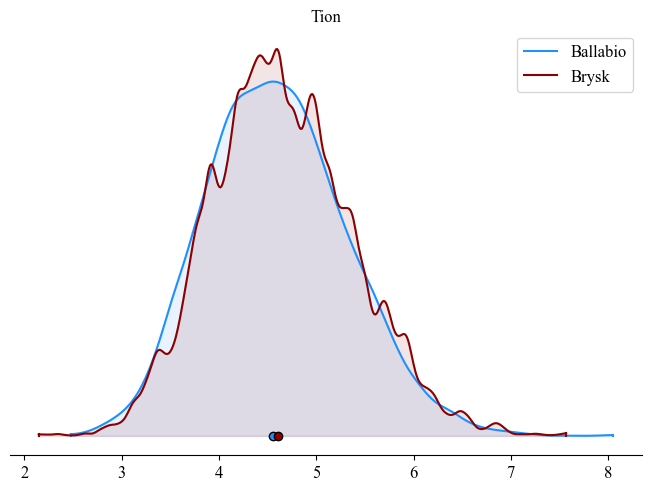

In [15]:
ax = az.plot_pair(post_az_ballabio,
            var_names=['Tion','amplitude'],figsize = (4,4),
            kind='kde',
            marginals = True,
            divergences=True,
            textsize=20,
            kde_kwargs = {'contour_kwargs':{"colors":None, "cmap":plt.cm.Blues},
            'contourf_kwargs':{"alpha":0}},
            marginal_kwargs = {'kind':'hist','hist_kwargs':{'bins':15, 'color':'blue','alpha':0.25}})

az.plot_pair(post_az, ax = ax,
            var_names=['Tion','amplitude'],
            kind='kde',
            marginals = True,
            divergences=True,
            textsize=20,
            kde_kwargs = {'contour_kwargs':{"colors":None, "cmap":plt.cm.Reds},
            'contourf_kwargs':{"alpha":0}},
            marginal_kwargs = {'kind':'hist','hist_kwargs':{'bins':15, 'color':'red','alpha':0.25}})
ax[1][0].set_yticks([0.15, 0.2, 0.25, 0.3])
ax[1][0].set_xticks([2, 3,4.,5.0,6, 7])
#plt.legend()
#plt.savefig('compare_models.png',dpi=300,format = 'png')


new_ax = az.plot_density(
    [post_az_ballabio, post_az],
    data_labels=["Ballabio", "Brysk"],
    var_names=["Tion"],
    point_estimate = 'median',
    colors = ['dodgerblue', 'darkred'],
    shade=0.1,
    hdi_prob = 1,
)

plt.show()

Plotting the posterior predictive shows an excellent fit to the observation.

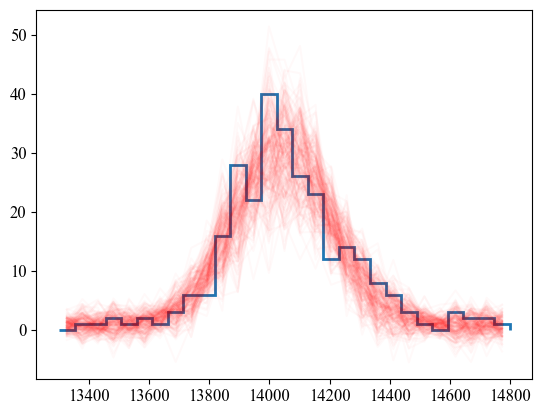

In [16]:
output_post = posterior_pred_ballabio['y_observed'][::100,:]
plt.stairs(data,E, linewidth=2)

for o in output_post:
    plt.plot(E_mid, o, color='red', alpha = 0.025)
    

Finally, we can improve the fidelity of our statistical model by changing the likelihood function.  We have until now assumed a Normal likelihood.  But, our data was modeled as a counting process using a Poisson distribution to generate an observed value based on a true value from the model.  If we use a Poisson likelihood the statistical process in our model will agree better with the actual measurment mechanism provided we are not in the large count limit where the two will converge to be in agreement. Note that the example values chosen here were meant to explicitly demonstrate this difference.  

The Poisson distribution takes only a rate parameter as its argument.  In our case, the rate is the predicted neutron output at a given energy.  There is also some base counting rate mean to mimic a noise floor of our detection mechanism.  We create a rate function to return the neutron spectrum if the simulated counts are greater than this base rate, or the base rate if the spectrum goes below this threshold.  We again use the ballabio to copmute the spectrum.  Because we are modeling the counting process differently, we now have different parameters: $\theta = \{ base, T_{ion}, Y\}$, where $Y$ is the neutron yield.  Because the yield can in principle vary over many orders of magnitude we sample the $\log_{10}$ of the yield and transform it to $Y$.  

We sample our new Poisson model using NUTS again.

In [17]:
def Rates(E,T,base,Y): 
    return 0.5*(E[1:]-E[:-1])*(ballabio(E,T)[1:]+ballabio(E,T)[:-1])*Y + base
    #return ballabio(E,T)*Y + base

with pm.Model() as poisson_model:
    base = pm.Uniform("base", lower=0.0, upper = 5.0)
    Tion = pm.Uniform('Tion',lower=0.5,upper=9.0)
    LogYield = pm.Uniform('LogYield',0,2)
    Yield = pm.Deterministic('Yield',10**(LogYield))
    y_observed = pm.Poisson(
        "y_observed",
        mu=Rates(E,Tion,base,Yield),
        observed=data
    )
    rates = pm.Deterministic('rates', Rates(E,Tion,base,Yield))
    prior = pm.sample_prior_predictive()
    posterior = pm.sample(draws = Samples)
    posterior_pred_poisson = pm.sample_posterior_predictive(posterior)
    post_az_poisson = az.from_pymc3(posterior)


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  app.launch_new_instance()
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [LogYield, Tion, base]
INFO:pymc3:NUTS: [LogYield, Tion, base]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 17 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 17 seconds.


The posterior distribution of the ion temperature shows a much narrower width with this new model.

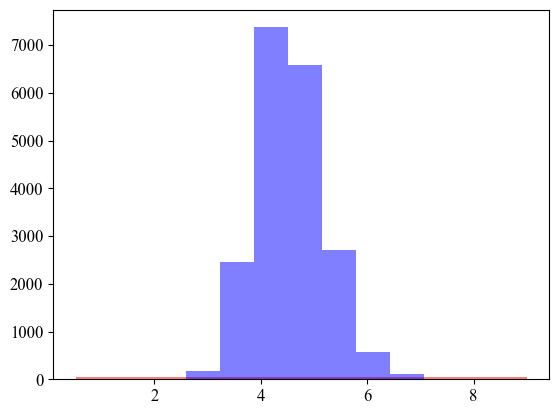

Ion Temperature Mean =  4.557430895485017
Ion Temperature Sted. Dev. =  0.6382250666510096


In [18]:
plt.hist(prior['Tion'],color='r',alpha=0.5)
plt.hist(posterior.get_values('Tion'),color='b',alpha=0.5)
plt.show()

print("Ion Temperature Mean = ", np.mean(posterior.get_values('Tion')))
print("Ion Temperature Sted. Dev. = ", np.std(posterior.get_values('Tion')))


Viewing the full posterior distribution with a corner plot we see that our new parameterization and statistical model exhibits some minor correlations between the model parameters.

array([[<AxesSubplot:ylabel='Tion'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='Yield'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='Tion', ylabel='base'>,
        <AxesSubplot:xlabel='Yield'>, <AxesSubplot:xlabel='base'>]],
      dtype=object)

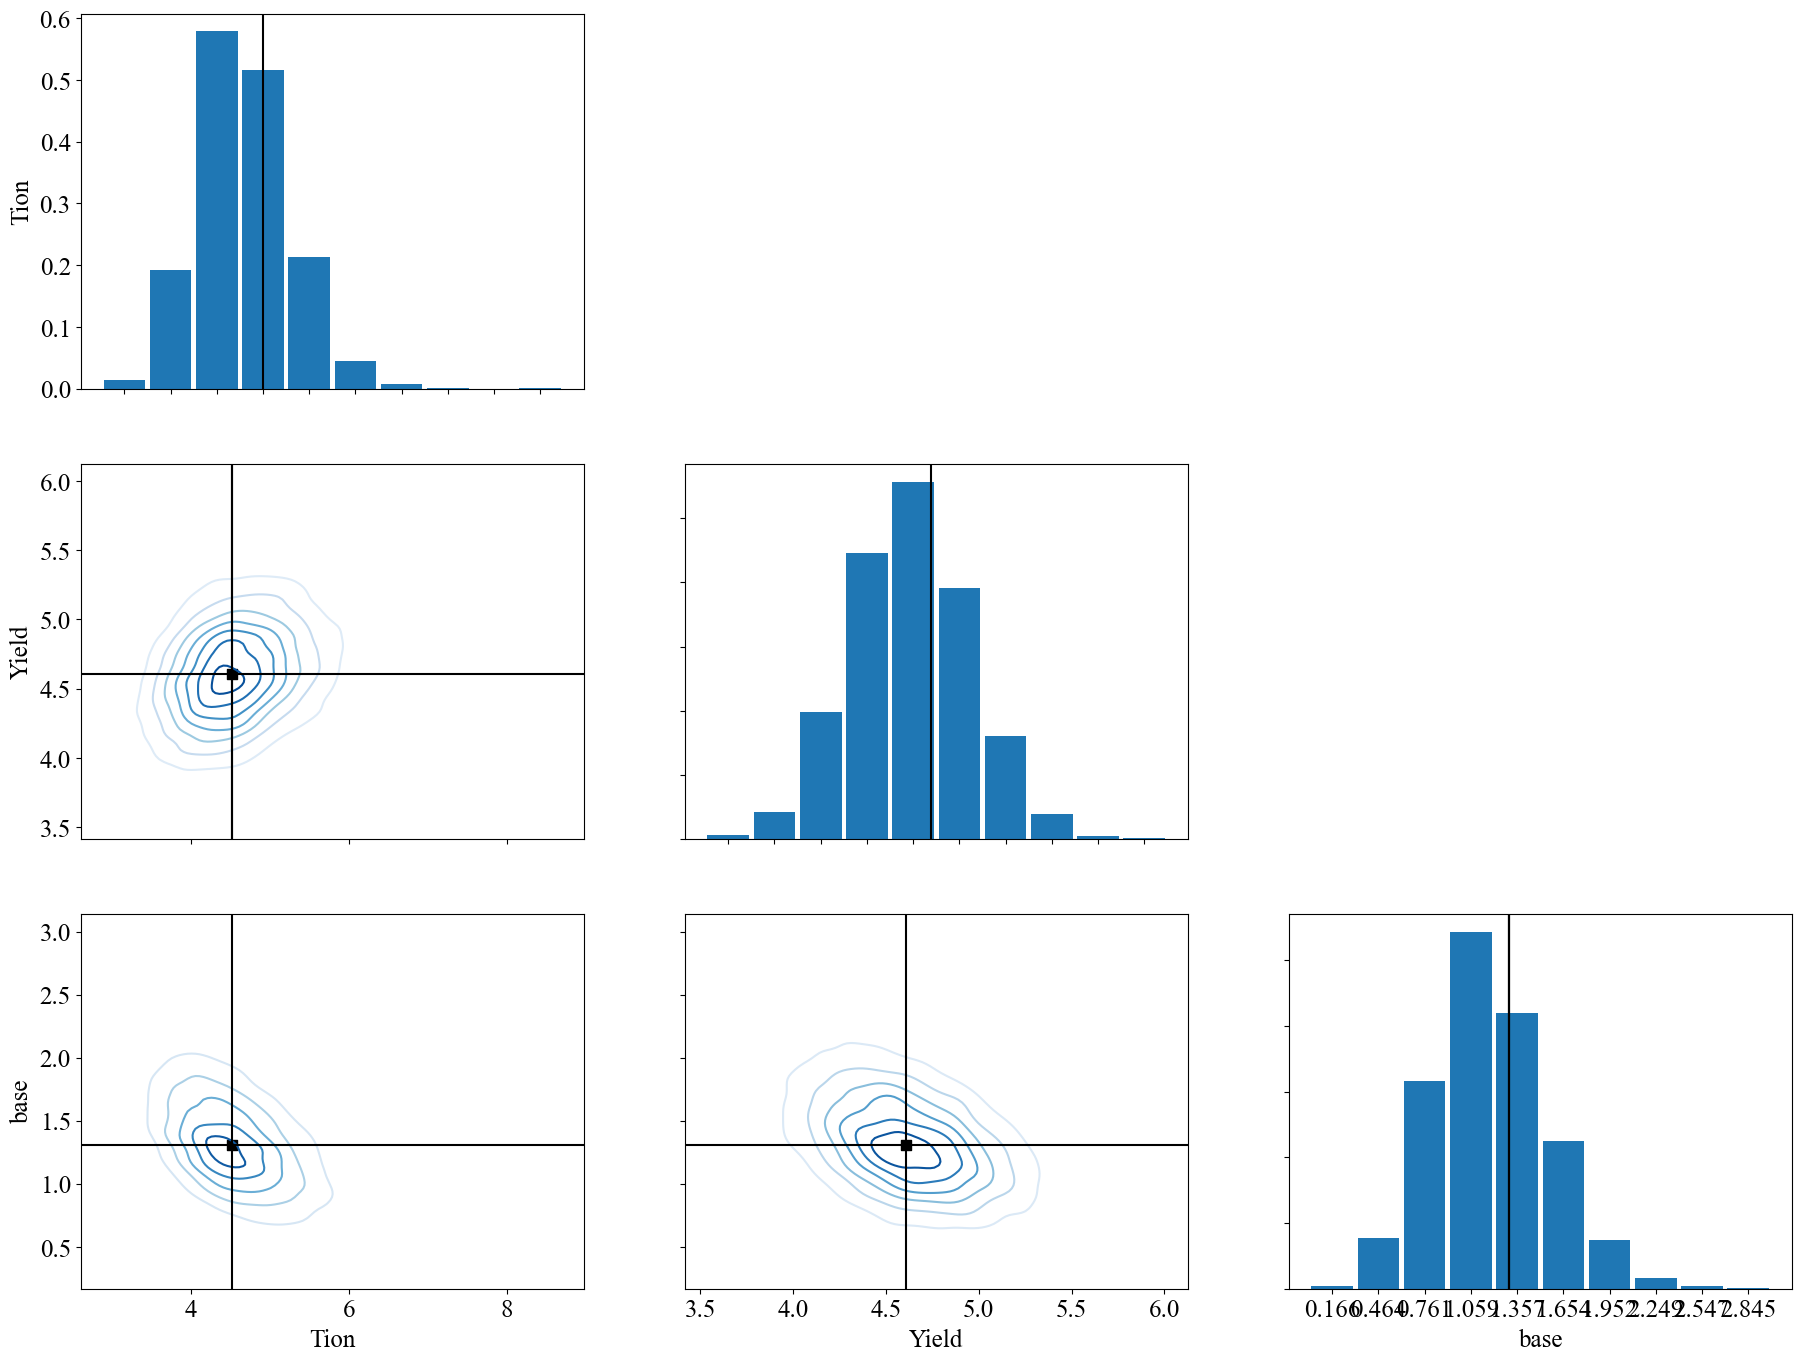

In [19]:
az.plot_pair(post_az_poisson,
            var_names=['Tion','Yield', 'base'],
            kind='kde',
            marginals = True,
            divergences=True,
            textsize=18,
            point_estimate = 'median',
            kde_kwargs = {'contour_kwargs':{"colors":None, "cmap":plt.cm.Blues},
            'contourf_kwargs':{"alpha":0}},
            marginal_kwargs = {'kind':'hist','hist_kwargs':{'bins':10}})


The posterior predictive is well behaved with an excellent match to the data.

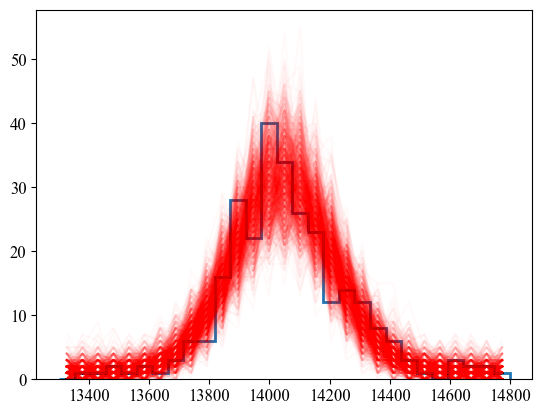

In [20]:
rates_post = posterior_pred_poisson['y_observed'][::20,:]
plt.stairs(data,E, linewidth=2)
for r in rates_post:
    plt.plot(E_mid, r, color='red', alpha = 0.025)

We can compare the marginal distribution for the ion temperature from each of the models demonstrated in the notebook.  The true value of the ion temperature is shown as the dashed black line.  We see that as we improve the fidelity of our statistical and physical models, the distribution narrows.  The true value is within one standard deviation of the peak in each case, but the quality of the inference steadily improves.  This illustrates why it is important to model both the physics and statistics of the measurement correctly when performing inference.

Text(0.5, 0, 'Ion Temperature [keV]')

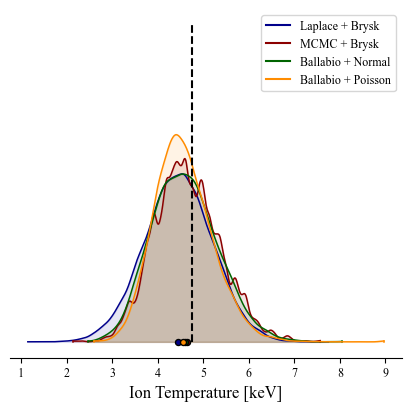

In [21]:
ax = az.plot_density(
    [dataset, post_az, post_az_ballabio, post_az_poisson],
    data_labels=["Laplace + Brysk", "MCMC + Brysk", "Ballabio + Normal", "Ballabio + Poisson"],
    var_names=["Tion"],
    colors = ['darkblue', 'darkred', 'darkgreen', 'darkorange'],
    shade=0.1,
    hdi_prob = 1.0,
    figsize = (4,4)
)
ax[0][0].plot([4.75,4.75], [0,1], c = 'k', ls = '--')
ax[0][0].set_title("")
ax[0][0].set_xlabel("Ion Temperature [keV]")
#ax[0][0].set_xlim([4.2,5.6])


We can compare the marginal distribution for the ion temperature from each of the models demonstrated in the notebook.  The true value of the ion temperature is shown as the dashed black line.  We see that as we improve the fidelity of our statistical and physical models, the distribution narrows.  The true value is within one standard deviation of the peak in each case, but the quality of the inference steadily improves.  This illustrates why it is important to model both the physics and statistics of the measurement correctly when performing inference.

## Laplace approximation with Poisson likelihood

Below we demonstrate the use of the Laplace approximation with a Poisson likelihood function.

In [22]:
## Jax-based Laplace solution for Ballabio + Poisson likelihood

import jax.scipy.optimize as jopt

def ballabio_j(E,ion_temp):    
 
    a1 = jnp.array([5.30509, 2.4736e-3, 1.84, 1.3818])
    a2 = jnp.array([5.1068e-4, 7.6223e-3, 1.78, 8.7691e-5])
    Eo = 14.021*1e3
    wo = 177.259
    Ti = ion_temp
    
    # computed parameters
    dE = (a1[0]/( 1 + a1[1]*Ti**a1[2] ))*Ti**( 2.0/3.0 ) + a1[3]*Ti
    dw = (a2[0]/( 1 + a2[1]*Ti**a2[2] ))*Ti**( 2.0/3.0 ) + a2[3]*Ti
    Emean = Eo + dE
    Sth = wo*(1+dw)*jnp.sqrt(Ti)/(2*jnp.sqrt(2*jnp.log(2)))

    Ebar = Emean*jnp.sqrt(1.0-1.5*Sth/Emean**2.0)
    S = (4./3.)*Ebar*(Emean-Ebar)        
    f = jnp.exp(-( 2*Ebar/S**2 ) * ( jnp.sqrt(E)-jnp.sqrt(Ebar))**2 ) 
    return f/jnp.sum(f)                  

def myfun_j(theta):
    T,base,Y = theta
    f = 0.5*(E[1:]-E[:-1])*(ballabio_j(E,T)[1:]+ballabio_j(E,T)[:-1])*Y + base#*jnp.ones(len(E)-1)
    return jnp.sum( -data*jnp.log(f) + f)


x0 = jnp.array([3.0, 5.0, 10.0])
x = jopt.minimize(myfun_j, x0, method = 'BFGS')#,bounds = [[1.0, 8.0], [0.1, 200.0], [1, 10000]])
print(x.x)


[3.4417975 1.4305063 4.5689964]


In [23]:
def ballabio_opt_model(E,ion_temp):    
 
    a1 = np.array([5.30509, 2.4736e-3, 1.84, 1.3818])
    a2 = np.array([5.1068e-4, 7.6223e-3, 1.78, 8.7691e-5])
    Eo = 14.021*1e3
    wo = 177.259
    Ti = ion_temp
    # computed parameters
    dE = (a1[0]/( 1 + a1[1]*Ti**a1[2] ))*Ti**( 2.0/3.0 ) + a1[3]*Ti
    dw = (a2[0]/( 1 + a2[1]*Ti**a2[2] ))*Ti**( 2.0/3.0 ) + a2[3]*Ti
    Emean = Eo + dE
    Sth = wo*(1+dw)*np.sqrt(Ti)/(2*np.sqrt(2*np.log(2)))

    Ebar = Emean*np.sqrt(1.0-1.5*Sth/Emean**2.0)
    S = (4./3.)*Ebar*(Emean-Ebar)        
    f = np.exp(-( 2*Ebar/S**2 ) * ( np.sqrt(E)-np.sqrt(Ebar))**2 )                   
    return f/np.sum(f)


def myfun_poiss(theta):
    T,base,Y = theta
    f = 0.5*(E[1:]-E[:-1])*(ballabio_opt_model(E,T)[1:]+ballabio_opt_model(E,T)[:-1])*Y + base
    return np.sum( -data*np.log(f) + f)

from scipy.optimize import minimize, least_squares
x0 = [4.0, 1.0, 1.0]
x = minimize(myfun_poiss, x0, method = 'L-BFGS-B',bounds = [[0.1, 10.0], [-5.0, 5.0], [0, 50]])
print(x["x"])

[4.47959603 1.25404634 4.63293312]


Ion Temperature Mean =  4.477883103685402
Ion Temperature Sted. Dev. =  0.6453992989572908


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  import sys


<Figure size 640x480 with 0 Axes>

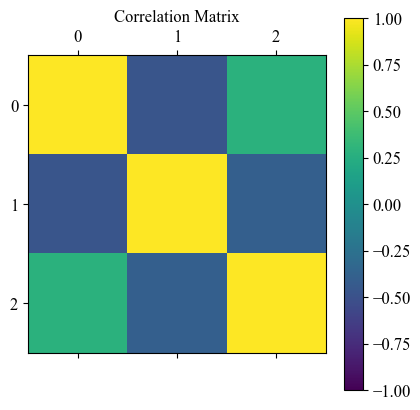

In [24]:
hessian = jit(jacfwd(jacrev(myfun_j)))

precision = hessian(np.array(x['x']))

cov = np.linalg.inv(precision)

mvsamples = np.random.multivariate_normal(x.x, -cov, size=40000)
datadict = {
    "Tion": mvsamples[:,0],
    "base": mvsamples[:,1],
    "Yield":mvsamples[:,2]
}
dataset_laplace_poisson = az.convert_to_inference_data(datadict)

corr = np.corrcoef(mvsamples, rowvar = False)
plt.figure()
plt.matshow(corr, vmin = -1, vmax = 1)
plt.colorbar()
plt.title("Correlation Matrix")

print("Ion Temperature Mean = ", np.mean(datadict["Tion"]))
print("Ion Temperature Sted. Dev. = ", np.std(datadict["Tion"]))


Text(0.5, 0, 'Ion Temperature [keV]')

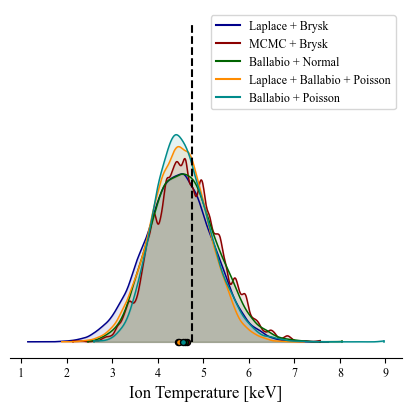

In [25]:
ax = az.plot_density(
    [dataset, post_az, post_az_ballabio, dataset_laplace_poisson, post_az_poisson],
    data_labels=["Laplace + Brysk", "MCMC + Brysk", "Ballabio + Normal", "Laplace + Ballabio + Poisson","Ballabio + Poisson"],
    var_names=["Tion"],
    colors = ['darkblue', 'darkred', 'darkgreen', 'darkorange', 'darkcyan'],
    shade=0.1,
    hdi_prob = 1.0,
    figsize = (4,4)
)
ax[0][0].plot([4.75,4.75], [0,1], c = 'k', ls = '--')
ax[0][0].set_title("")
ax[0][0].set_xlabel("Ion Temperature [keV]")
#ax[0][0].set_xlim([4.2,5.6])



/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/arviz/plots/pairplot.py:229: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  UserWarning,


array([[<AxesSubplot:ylabel='Tion'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='base'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='Tion', ylabel='Yield'>,
        <AxesSubplot:xlabel='base'>, <AxesSubplot:xlabel='Yield'>]],
      dtype=object)

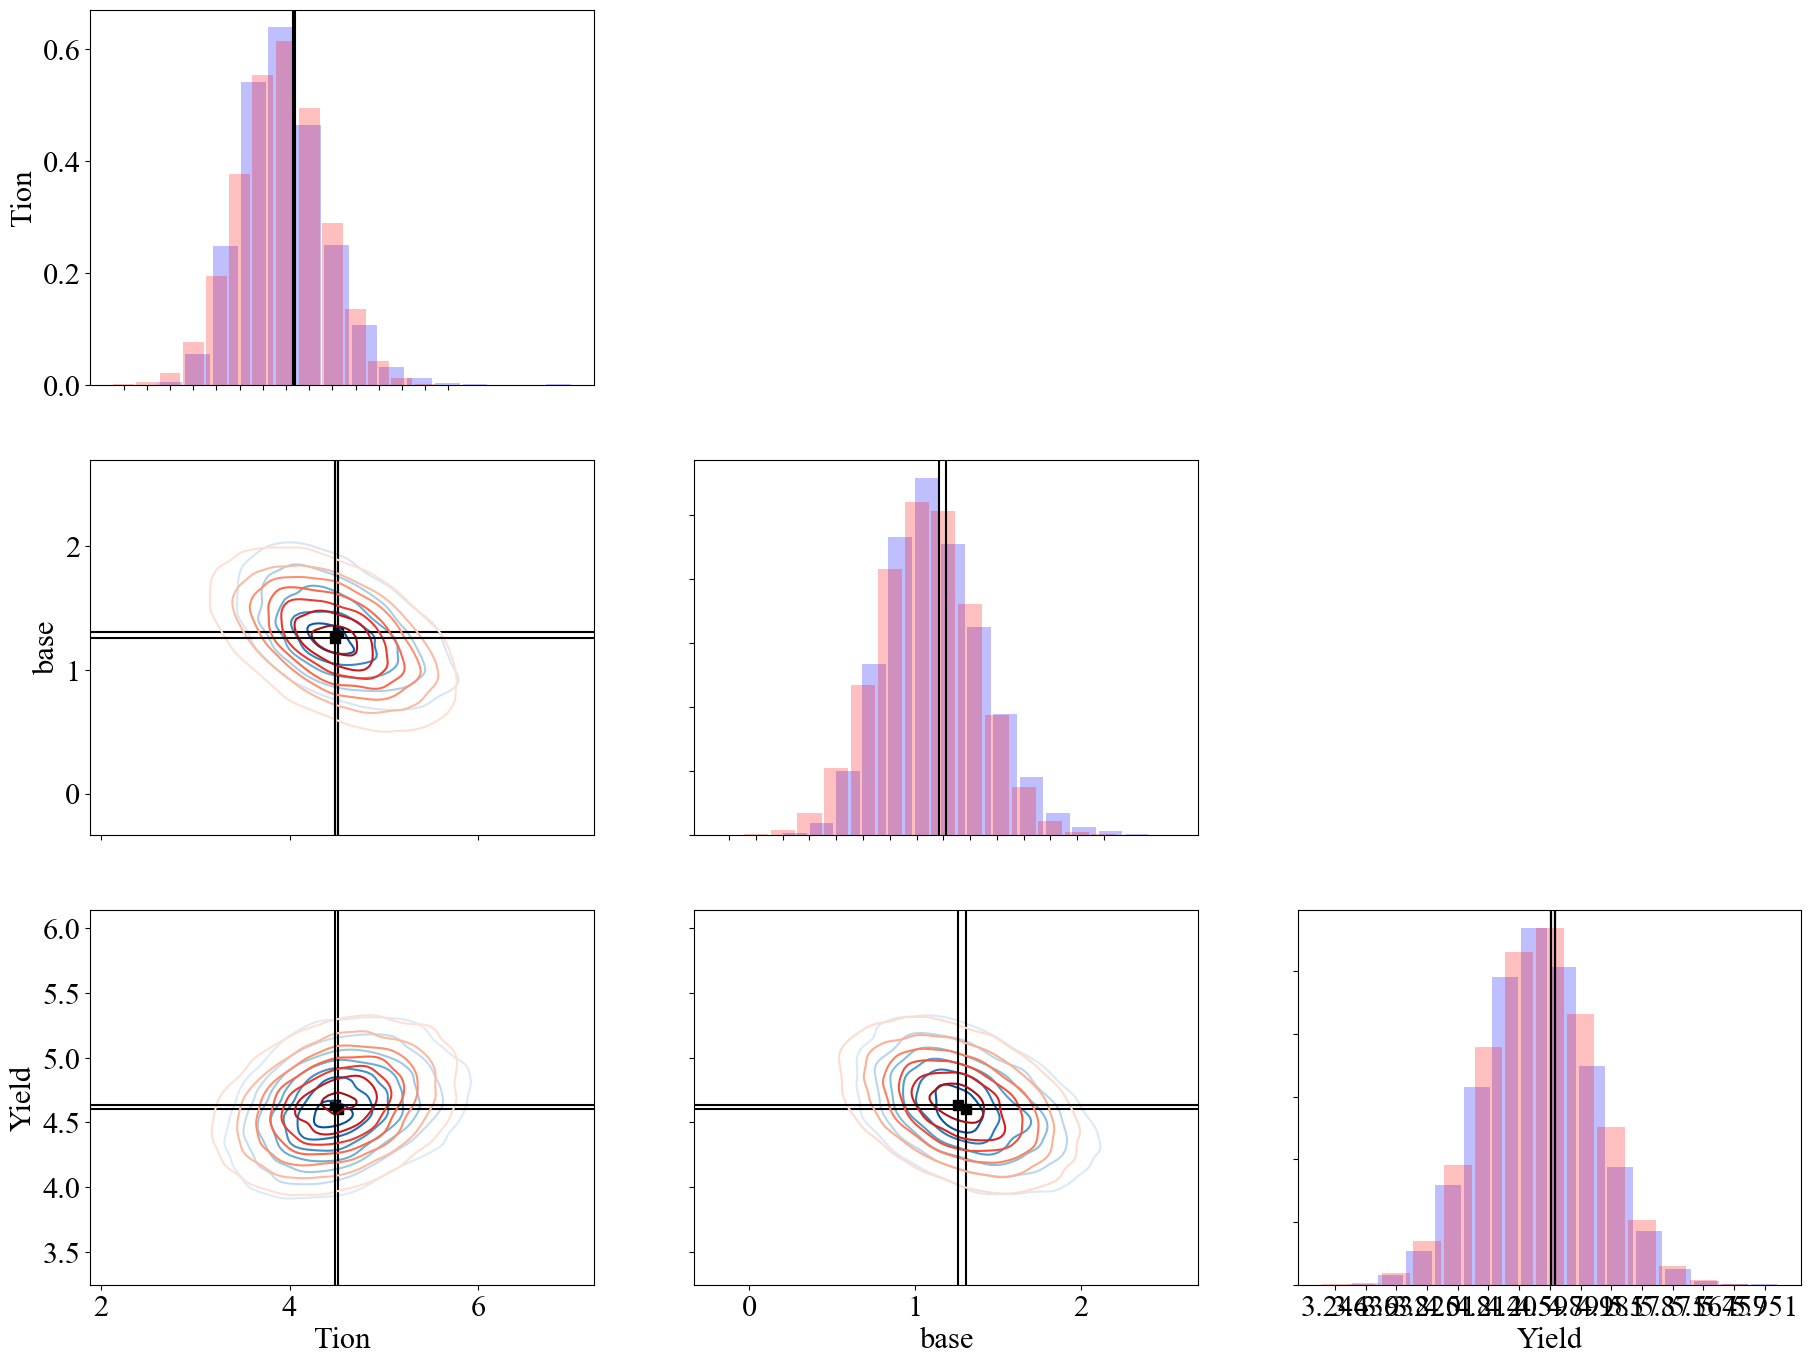

In [26]:

ax = az.plot_pair(post_az_poisson,
            var_names=['Tion','base', 'Yield'],
            kind='kde',
            marginals = True,
            divergences=True,
            textsize=22,
            point_estimate = 'median',
            kde_kwargs = {'contour_kwargs':{"colors":None, "cmap":plt.cm.Blues},
            'contourf_kwargs':{"alpha":0}},
            marginal_kwargs = {'kind':'hist','hist_kwargs':{'bins':15, 'color':'blue','alpha':0.25}})

az.plot_pair(dataset_laplace_poisson, ax = ax,
            var_names=['Tion','base', 'Yield'],
            kind='kde',
            marginals = True,
            divergences=True,
            textsize=22,
            point_estimate = 'median',
            kde_kwargs = {'contour_kwargs':{"colors":None, "cmap":plt.cm.Reds},
            'contourf_kwargs':{"alpha":0}},
            marginal_kwargs = {'kind':'hist','hist_kwargs':{'bins':15, 'color':'red','alpha':0.25}})             


(-0.05, 1.25)

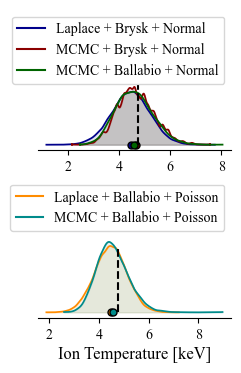

In [27]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize = (2.5,4), sharey=False)

az.plot_density(
    [dataset, post_az, post_az_ballabio],
    data_labels=["Laplace + Brysk + Normal", "MCMC + Brysk + Normal", "MCMC + Ballabio + Normal"],
    var_names=["Tion"],
    colors = ['darkblue', 'darkred', 'darkgreen', 'darkorange', 'darkcyan'],
    shade=0.1,
    hdi_prob = 1.0,
    ax = ax1,
    textsize = 10
)
ax1.plot([4.75,4.75], [0,0.6], c = 'k', ls = '--')
ax1.set_title("")
#ax1.set_xlabel("Ion Temperature [keV]")
#ax1.set_xlim([2,7])
ax1.set_ylim([-0.05, 1.35])

az.plot_density(
    [dataset_laplace_poisson, post_az_poisson],
    data_labels=["Laplace + Ballabio + Poisson","MCMC + Ballabio + Poisson"],
    var_names=["Tion"],
    colors = ['darkorange', 'darkcyan'],
    shade=0.1,
    hdi_prob = 1.0,
    ax = ax2,
    textsize = 10
)

ax2.plot([4.75,4.75], [0,0.6], c = 'k', ls = '--')
ax2.set_title("")
ax2.set_xlabel("Ion Temperature [keV]")
#ax2.set_xlim([2,7])
ax2.set_ylim([-0.05, 1.25])

#plt.savefig('compare_models_inference.jpg',dpi=300,format = 'jpeg')


We can use statistical test to quantitatively compare our models.  The test shown below (Paired Leave One Out cross validation: LOO) not only weights the quality of the fit but also the number of parameters in the model.  Here we compare the Ballabio + Poisson model, Ballabio + Normal, and Brysk + Normal models using the `az.compare` method.  The resulting table ranks the models in order of quality, with rank = 0 being the best.  The resulting plot alos shows the score with higher score being better. Note that the poisson likelihood + Ballabio performs best, as expected, since this is accurately matched to the data generating process. The Normal + Ballabio is next and performs better than Brysk + Normal at least in part due to the existence of fewer free parameters.

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:147: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:913: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
poisson,0,-63.386457,2.824747,0.000000,1.000000e+00,4.927751,0.000000,False,log
ballabio,1,-65.179124,2.528214,1.792667,0.000000e+00,4.570776,0.644351,False,log
normal,2,-66.488429,3.735140,3.101972,7.327472e-15,5.009870,0.916571,False,log


[Text(0, 0.0, 'Poisson + Ballabio'),
 Text(0, -0.375, ''),
 Text(0, -0.5, 'Normal + Ballabio'),
 Text(0, -0.875, ''),
 Text(0, -1.0, 'Normal + Brysk')]

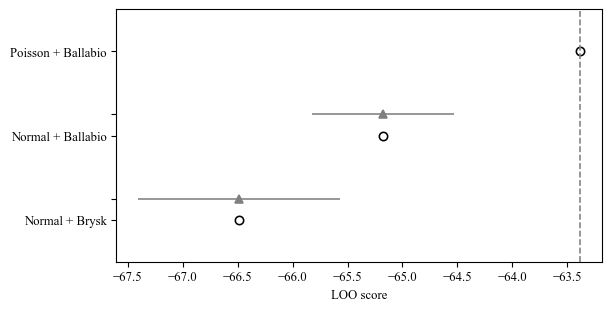

In [28]:
compare_dict = {"poisson" : post_az_poisson, "ballabio" : post_az_ballabio, "normal":post_az}
compare_models = az.compare(compare_dict, ic = 'loo')
display(compare_models)

ax = az.plot_compare(compare_models, insample_dev=False, plot_ic_diff = True, plot_standard_error = False)
ax.set_xlabel('LOO score')
ax.set_yticklabels(["Poisson + Ballabio" ,'', "Normal + Ballabio",'',  "Normal + Brysk"])
#plt.savefig('compare_models_loo.jpg',dpi=300,format = 'jpeg')

In [29]:
az.compare(compare_dict)

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:147: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:913: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
poisson,0,-63.386457,2.824747,0.000000,1.000000e+00,4.927751,0.000000,False,log
ballabio,1,-65.179124,2.528214,1.792667,0.000000e+00,4.570776,0.644351,False,log
normal,2,-66.488429,3.735140,3.101972,7.327472e-15,5.009870,0.916571,False,log
